## make semi supervised

In [110]:
from genepy.utils import helper as h

# to comment in your case
from taigapy import TaigaClient
tc = TaigaClient()

from celligner2.dataset import anndata
import pandas as pd
# to comment in your case
from depmapomics import tracker as track

from collections import Counter

#autoreload
%load_ext autoreload
%autoreload 2
#output
from bokeh.plotting import output_notebook
output_notebook()
from anndata import AnnData, read_h5ad

import scanpy as sc
import torch
import matplotlib.pyplot as plt
import numpy as np
import gdown

import celligner2
from celligner2 import plotting as pl

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Loading BokehJS ...

In [3]:
sc.settings.set_figure_params(dpi=500, frameon=False)
sc.set_figure_params(dpi=500)
sc.set_figure_params(figsize=(10, 10))
torch.set_printoptions(precision=3, sci_mode=False, edgeitems=7)

In [ ]:
dataset = read_h5ad("temp/celligner_multi.h5ad.gz")

In [4]:
dataset.X.shape

(13647, 29643)

In [5]:
dataset.X.max()**2

347.3510313814186

In [162]:
Counter(dataset.obs.tissue_type)

Counter({'lung': 1308,
         'soft_tissue': 552,
         'skin': 557,
         'bile_duct': 79,
         'urinary_tract': 443,
         'colorectal': 454,
         'lymphocyte': 181,
         'uterus': 278,
         'gastric': 461,
         'kidney': 1057,
         'pancreas': 232,
         'central_nervous_system': 1307,
         'fibroblast': 39,
         'breast': 1160,
         'bone': 302,
         'upper_aerodigestive': 576,
         'ovary': 491,
         'cervix': 325,
         'blood': 1221,
         'esophagus': 214,
         nan: 25,
         'liver': 422,
         'peripheral_nervous_system': 212,
         'eye': 92,
         'thyroid': 532,
         'plasma_cell': 29,
         'engineered_central_nervous_system': 1,
         'embryo': 3,
         'engineered_kidney': 2,
         'prostate': 507,
         'engineered_ovary': 1,
         'engineered': 6,
         'engineered_prostate': 1,
         'engineered_lung': 1,
         'adrenal_cortex': 1,
         'engineered_b

In [6]:
dataset.obs.cell_type = dataset.obs.cell_type.replace({'historical_CL; 2D':'historical_cl'})

In [7]:
rename = {np.nan: "unknown", "adrenal_cortex": "adrenal", "colorectal": "colon", 'thymus': 'thyroid',}
dataset.obs.tissue_type = dataset.obs.tissue_type.replace(rename)

In [8]:
for val in ['ends', 'reference', 'method', 'sequencer']:
    print(val, set(dataset.obs[val]))

ends {'paired end'}
reference {'hg38'}
method {'bulk'}
sequencer {'Illumina Hiseq 2000'}


In [9]:
loc = np.argsort(dataset.X.var(0))[-3000:]
dataset = AnnData(dataset.X[:,loc], dataset.obs, dataset.var.iloc[loc])

In [109]:
set(dataset.obs.sex)

{'Female', 'Male', 'U', 'female', 'male', nan, 'not reported', 'unknown'}

In [10]:
dataset.obs.sex = dataset.obs.sex.str.lower()

In [15]:
for val in ['tissue_type', 'age', "sex", 'disease_type']:  
    loc = dataset.obs[val].isin(['unknown', 'not reported', 'Unknown', 'u']) | dataset.obs[val].isna()
    try:
        dataset.obs.loc[loc, val] = 'U'
    except TypeError:
        dataset.obs[val] = dataset.obs[val].cat.add_categories('U')
        dataset.obs.loc[loc, val] = 'U'

In [16]:
# removing ultra rare samples
loc = dataset.obs["disease_type"].isin([
'Teratoma',
'Thymic Cancer',
'Nasopharyngeal Cancer',
'U',
'Endocrine Cancer',
'Pineal Cancer',
'Embryonal Cancer',
"Gallbladder Cancer"]) | dataset.obs["tissue_type"].isin([
'engineered_central_nervous_system',
'embryo',
'engineered_kidney',
'engineered_ovary',
'engineered',
'engineered_prostate',
'engineered_lung',
'adrenal_cortex',
'engineered_blood',
'engineered_breast',
'colon',
'nasopharynx',
'teratoma',
'endocrine',
'pineal'])

dataset = AnnData(dataset.X[~loc.values], dataset.obs[~loc], var=dataset.var)

In [12]:
#TODO: try batch norm use_bn=True, use_ln=False, https://stats.stackexchange.com/questions/474440/why-do-transformers-use-layer-norm-instead-of-batch-norm
#TODO

In [14]:
loc = dataset.obs.cell_type=='tumor'
subdataset = AnnData(dataset.X[loc.values], dataset.obs[loc])

In [14]:
set(dataset.obs.sex)

{'U', 'female', 'male'}

In [6]:
dataset = read_h5ad("temp/cleanup_multi.h5ad.gz")

## unsupervised

In [16]:
toprovide = dataset.copy()

In [31]:
cl2_less = celligner2.CELLIGNER2(
    adata=dataset[dataset.obs.dataset.isin(['ccle', 'tcga', 'cclf'])].copy(),
    condition_keys=['dataset'],# 'sample_type', 'reference', 'cell_format'],
    predictor_keys=[],#'tissue_type', 'age', "sex", 'disease_type'],
    hidden_layer_sizes=[256, 128],
    #classifier_hidden_layer_sizes=[32,64],
    use_mmd = True,
    latent_dim=16,
    beta=500,
    #betaclass=0.8,
    main_dataset='tcga',
    #mmd_on='y1'
)
cl2_less.train(
    n_epochs=300,
    alpha_epoch_anneal=200,
    cell_type_key='lineage',
    early_stopping_kwargs= {
        "early_stopping_metric": "val_unweighted_loss",
        "threshold": 0,
        "patience": 30,
        "reduce_lr": True,
        "lr_patience": 15,
        "lr_factor": 0.1,
    },
    alpha_kl=0.001,
    train_frac=0.8,
    batch_size=150,
    #monitor_only_val=False,
    n_workers=8,
    min_weight=0.000001,
)


INITIALIZING NEW NETWORK..............
Encoder Architecture:
	Input Layer in, out and cond: 3000 256 3
	Hidden Layer 1 in/out: 256 128
	Mean/Var Layer in/out: 128 16
Classifier Architecture:
	First Layer in/out:  16 64
	Hidden Layer 1 in/out: 64 32
	Output Layer in/out:  32 0 

Decoder Architecture:
	First Layer in, out and cond:  16 128 3
	Hidden Layer 1 in/out: 128 256
	Output Layer in/out:  256 3000 



/home/jeremie/miniconda3/envs/gae/lib/python3.8/site-packages/torch/nn/init.py:388: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")
/home/jeremie/celligner2/celligner2/dataset/celligner2/anndata.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.goodloc = torch.tensor(goodloc, dtype=torch.bool)


 |██------------------| 13.3%  - val_loss: 6531.6436574836 - val_recon_loss: 4875.5085063734 - val_kl_loss: 64.7438756039 - val_class_ce_loss: 0.0000000000 - val_mmd_loss: 1656.1224268863

NotImplementedError: There were no tensor arguments to this function (e.g., you passed an empty list of Tensors), but no fallback function is registered for schema aten::_cat.  This usually means that this function requires a non-empty list of Tensors, or that you (the operator writer) forgot to register a fallback function.  Available functions are [CPU, QuantizedCPU, BackendSelect, Named, ADInplaceOrView, AutogradOther, AutogradCPU, AutogradCUDA, AutogradXLA, UNKNOWN_TENSOR_TYPE_ID, AutogradMLC, AutogradHPU, AutogradNestedTensor, AutogradPrivateUse1, AutogradPrivateUse2, AutogradPrivateUse3, Tracer, Autocast, Batched, VmapMode].

CPU: registered at /opt/conda/conda-bld/pytorch_1631630788697/work/build/aten/src/ATen/RegisterCPU.cpp:16286 [kernel]
QuantizedCPU: registered at /opt/conda/conda-bld/pytorch_1631630788697/work/build/aten/src/ATen/RegisterQuantizedCPU.cpp:1025 [kernel]
BackendSelect: fallthrough registered at /opt/conda/conda-bld/pytorch_1631630788697/work/aten/src/ATen/core/BackendSelectFallbackKernel.cpp:3 [backend fallback]
Named: registered at /opt/conda/conda-bld/pytorch_1631630788697/work/aten/src/ATen/core/NamedRegistrations.cpp:7 [backend fallback]
ADInplaceOrView: fallthrough registered at /opt/conda/conda-bld/pytorch_1631630788697/work/aten/src/ATen/core/VariableFallbackKernel.cpp:60 [backend fallback]
AutogradOther: registered at /opt/conda/conda-bld/pytorch_1631630788697/work/torch/csrc/autograd/generated/VariableType_2.cpp:9928 [autograd kernel]
AutogradCPU: registered at /opt/conda/conda-bld/pytorch_1631630788697/work/torch/csrc/autograd/generated/VariableType_2.cpp:9928 [autograd kernel]
AutogradCUDA: registered at /opt/conda/conda-bld/pytorch_1631630788697/work/torch/csrc/autograd/generated/VariableType_2.cpp:9928 [autograd kernel]
AutogradXLA: registered at /opt/conda/conda-bld/pytorch_1631630788697/work/torch/csrc/autograd/generated/VariableType_2.cpp:9928 [autograd kernel]
UNKNOWN_TENSOR_TYPE_ID: registered at /opt/conda/conda-bld/pytorch_1631630788697/work/torch/csrc/autograd/generated/VariableType_2.cpp:9928 [autograd kernel]
AutogradMLC: registered at /opt/conda/conda-bld/pytorch_1631630788697/work/torch/csrc/autograd/generated/VariableType_2.cpp:9928 [autograd kernel]
AutogradHPU: registered at /opt/conda/conda-bld/pytorch_1631630788697/work/torch/csrc/autograd/generated/VariableType_2.cpp:9928 [autograd kernel]
AutogradNestedTensor: registered at /opt/conda/conda-bld/pytorch_1631630788697/work/torch/csrc/autograd/generated/VariableType_2.cpp:9928 [autograd kernel]
AutogradPrivateUse1: registered at /opt/conda/conda-bld/pytorch_1631630788697/work/torch/csrc/autograd/generated/VariableType_2.cpp:9928 [autograd kernel]
AutogradPrivateUse2: registered at /opt/conda/conda-bld/pytorch_1631630788697/work/torch/csrc/autograd/generated/VariableType_2.cpp:9928 [autograd kernel]
AutogradPrivateUse3: registered at /opt/conda/conda-bld/pytorch_1631630788697/work/torch/csrc/autograd/generated/VariableType_2.cpp:9928 [autograd kernel]
Tracer: registered at /opt/conda/conda-bld/pytorch_1631630788697/work/torch/csrc/autograd/generated/TraceType_2.cpp:9621 [kernel]
Autocast: registered at /opt/conda/conda-bld/pytorch_1631630788697/work/aten/src/ATen/autocast_mode.cpp:259 [kernel]
Batched: registered at /opt/conda/conda-bld/pytorch_1631630788697/work/aten/src/ATen/BatchingRegistrations.cpp:1019 [backend fallback]
VmapMode: fallthrough registered at /opt/conda/conda-bld/pytorch_1631630788697/work/aten/src/ATen/VmapModeRegistrations.cpp:33 [backend fallback]


In [7]:
dataset.obs.replace({'tissue_type':{'engineered': 'u', 'unknown': 'u',
 'engineered_blood': 'blood',
 'engineered_breast': 'breast',
 'engineered_central_nervous_system': 'central_nervous_system',
 'engineered_kidney': 'kidney',
 'engineered_lung': 'lung',
 'engineered_ovary': 'ovary',
 'engineered_prostate': 'prostate',
 np.nan: 'u'}}, inplace=True)

In [8]:
dataset.obs.replace({'lineage':{
 'fibroblast_bone': 'fibroblast',
 'fibroblast_breast': 'fibroblast',
 'fibroblast_lung': 'fibroblast',
 'fibroblast_skin': 'fibroblast',}}, inplace=True)

In [13]:
evaluator = pl.CELLIGNER2_EVAL(cl2_less)

In [14]:
evaluator.adata_latent.obs[['disease_type', 'sex', 'age', 'lineage']] = dataset.obs.loc[evaluator.adata_latent.obs.index, ['disease_type', 'sex', 'age', 'lineage']]

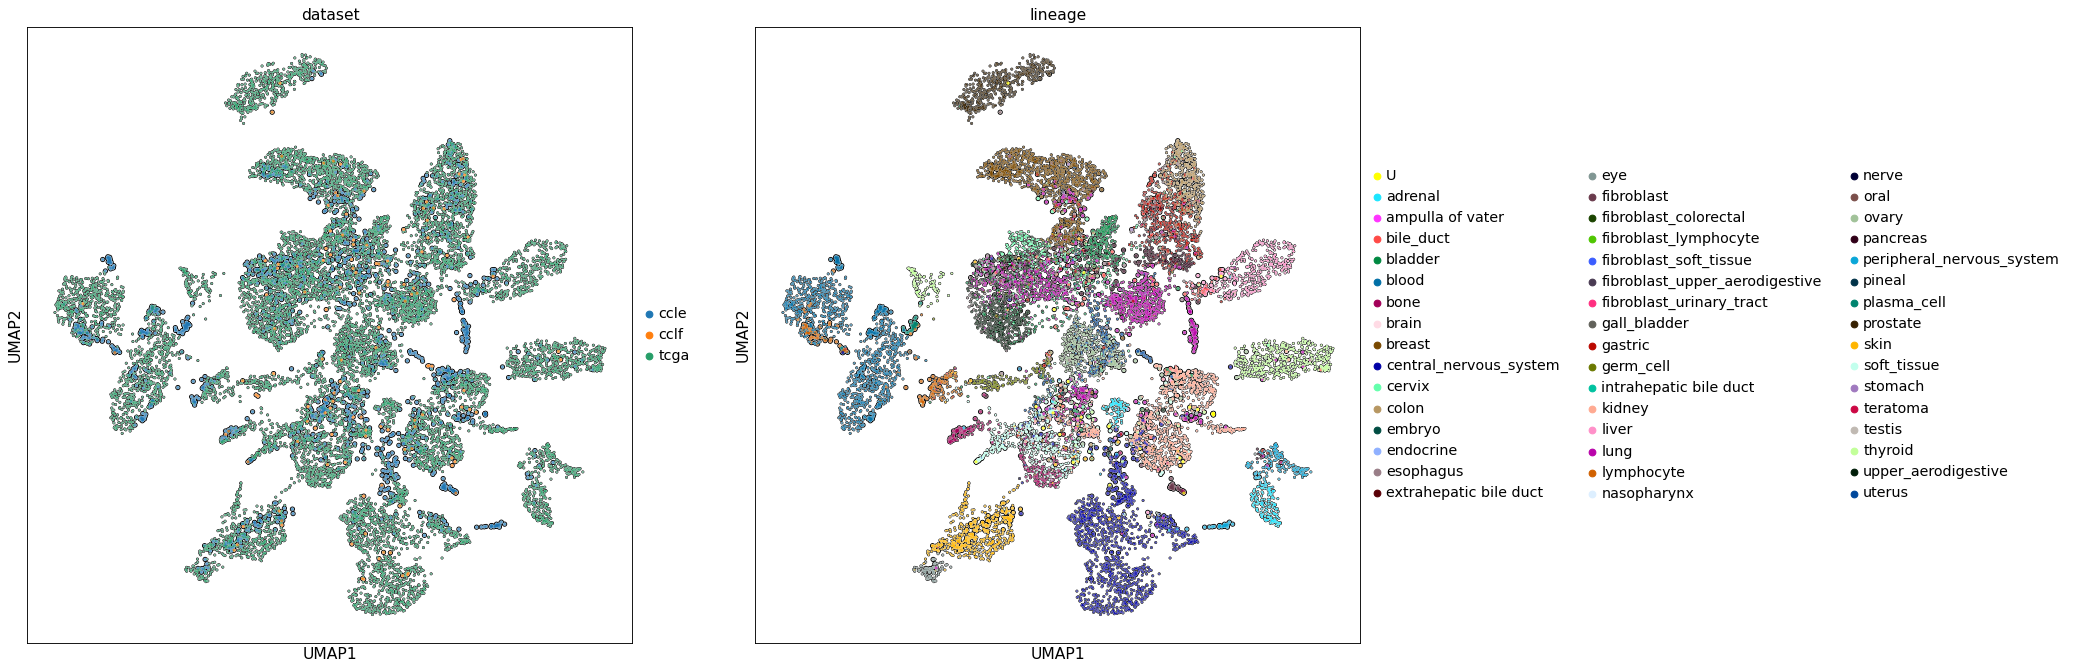

In [15]:
evaluator.plot_latent(umap_kwargs=dict( 
                            n_components=2,
                            min_dist=0.5,
                            alpha=1,
                            spread=1,
                            random_state=None), 
        color=['dataset', 'lineage'],
        projection="2d",
        add_outline=True,
        #rerun=False,
        size=[30 if i != 'tcga' else 10 for i in  evaluator.adata_latent.obs['dataset']])

In [126]:
adata_obs = read_h5ad('../celligner/temp/adata.h5ad.gz').obs

In [ ]:
dataset.obs.drop(columns=['cell_type', 'tissue_type'], inplace=True)
evaluator.adata_latent.obs.drop(columns=['cell_type', 'tissue_type'], inplace=True)

In [171]:
dataset.obs.loc[set(adata_obs.index) & set(evaluator.adata_latent.obs.index),['tissue_type','cell_type']] = adata_obs.loc[set(adata_obs.index) & set(evaluator.adata_latent.obs.index), ['tissue_type','cell_type']]

In [172]:
evaluator.adata_latent.obs.loc[set(adata_obs.index) & set(evaluator.adata_latent.obs.index),['tissue_type','cell_type']] = adata_obs.loc[set(adata_obs.index) & set(evaluator.adata_latent.obs.index), ['tissue_type','cell_type']]

In [173]:
loc = ~evaluator.adata_latent.obs.cell_type.isna()

In [174]:
dataset.obs.cell_type = dataset.obs.cell_type.astype('category')
dataset.obs.tissue_type = dataset.obs.tissue_type.astype('category')
evaluator.adata_latent.obs.cell_type = evaluator.adata_latent.obs.cell_type.astype('category')
evaluator.adata_latent.obs.tissue_type = evaluator.adata_latent.obs.tissue_type.astype('category')

In [175]:
evaluator.adata_latent.obsm['X_pca'] = evaluator.adata_latent.X

In [166]:
scib.metrics.metrics(dataset[evaluator.adata_latent[loc].obs.index], evaluator.adata_latent[loc], batch_key="cell_type", label_key='tissue_type', cell_cycle_=False, organism='human', trajectory_=False, isolated_labels_asw_=True, silhouette_=True, hvg_score_=False, graph_conn_=True, pcr_=True, isolated_labels_f1_=False, nmi_=True, ari_=True, kBET_=True, ilisi_=True, clisi_=True,)

Trying to set attribute `.obs` of view, copying.


NMI...
ARI...
Silhouette score...
PC regression...
Isolated labels ASW...
Graph connectivity...
kBET...
cLISI score...
/tmp/lisi_2wu2to9b/input.mtx /tmp/lisi_2wu2to9b/
iLISI score...
/tmp/lisi_0cwtqhfv/input.mtx /tmp/lisi_0cwtqhfv/


0
NMI_cluster/label          0.751766
ARI_cluster/label          0.606128
ASW_label                  0.514303
ASW_label/batch            0.777834
PCR_batch                  0.999638
cell_cycle_conservation         NaN
isolated_label_F1               NaN
isolated_label_silhouette  0.471067
graph_conn                 0.869212
kBET                            NaN
iLISI                      0.057753
cLISI                      0.904041
hvg_overlap                     NaN
trajectory                      NaN

In [189]:
cl2_less.save("temp/subdataset_trial2_noclass", overwrite=True)

In [4]:
cl2_less = celligner2.CELLIGNER2.load_query_data(adata=dataset[dataset.obs.dataset.isin(['met500', 'pediatric_PDX', 'hcmi'])].copy(), reference_model='temp/subdataset_trial2_noclass')

NameError: name 'dataset' is not defined

In [6]:
cl2_less.train(
    n_epochs=300,
    alpha_epoch_anneal=200,
    early_stopping_kwargs={
        "early_stopping_metric": "val_unweighted_loss",
        "threshold": 0,
        "patience": 20,
        "reduce_lr": True,
        "lr_patience": 13,
        "lr_factor": 0.1,
    },
    weight_decay=0,
    batch_size=100,
    train_frac=0.8,
    #monitor_only_val=False,
    n_workers=16,
)

         Falling back to preprocessing with `sc.pp.pca` and default params.


using leiden clustering to define training group mixing


         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
/home/jeremie/celligner2/celligner2/dataset/celligner2/anndata.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.goodloc = torch.tensor(goodloc, dtype=torch.bool)
/home/jeremie/miniconda3/envs/gae/lib/python3.8/site-packages/torch/utils/data/dataloader.py:478: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


 |██------------------| 11.7%  - val_loss: 7190.9244791667 - val_recon_loss: 5179.1328125000 - val_kl_loss: 65.7513580322 - val_class_ce_loss: 0.0000000000 - val_mmd_loss: 2011.7803955078
ADJUSTED LR
 |███-----------------| 18.3%  - val_loss: 7196.2760416667 - val_recon_loss: 5217.0195312500 - val_kl_loss: 65.7530924479 - val_class_ce_loss: 0.0000000000 - val_mmd_loss: 1979.2391764323
ADJUSTED LR
 |████----------------| 20.7%  - val_loss: 8446.9863281250 - val_recon_loss: 5205.3675130208 - val_kl_loss: 65.7534739176 - val_class_ce_loss: 0.0000000000 - val_mmd_loss: 3241.5990397135
Stopping early: no improvement of more than 0 nats in 20 epochs
If the early stopping criterion is too strong, please instantiate it with different parameters in the train method.
Saving best state of network...
Best State was in Epoch 40


In [ ]:
evaluator = pl.CELLIGNER2_EVAL(cl2_less)

In [ ]:
evaluator.adata_latent.obs[['disease_type', 'sex', 'age', 'lineage']] = dataset[dataset.obs.dataset.isin(['met500', 'pediatric_PDX', 'hcmi'])].obs[['disease_type', 'sex', 'age', 'lineage']]

/home/jeremie/miniconda3/envs/gae/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'dataset' as categorical


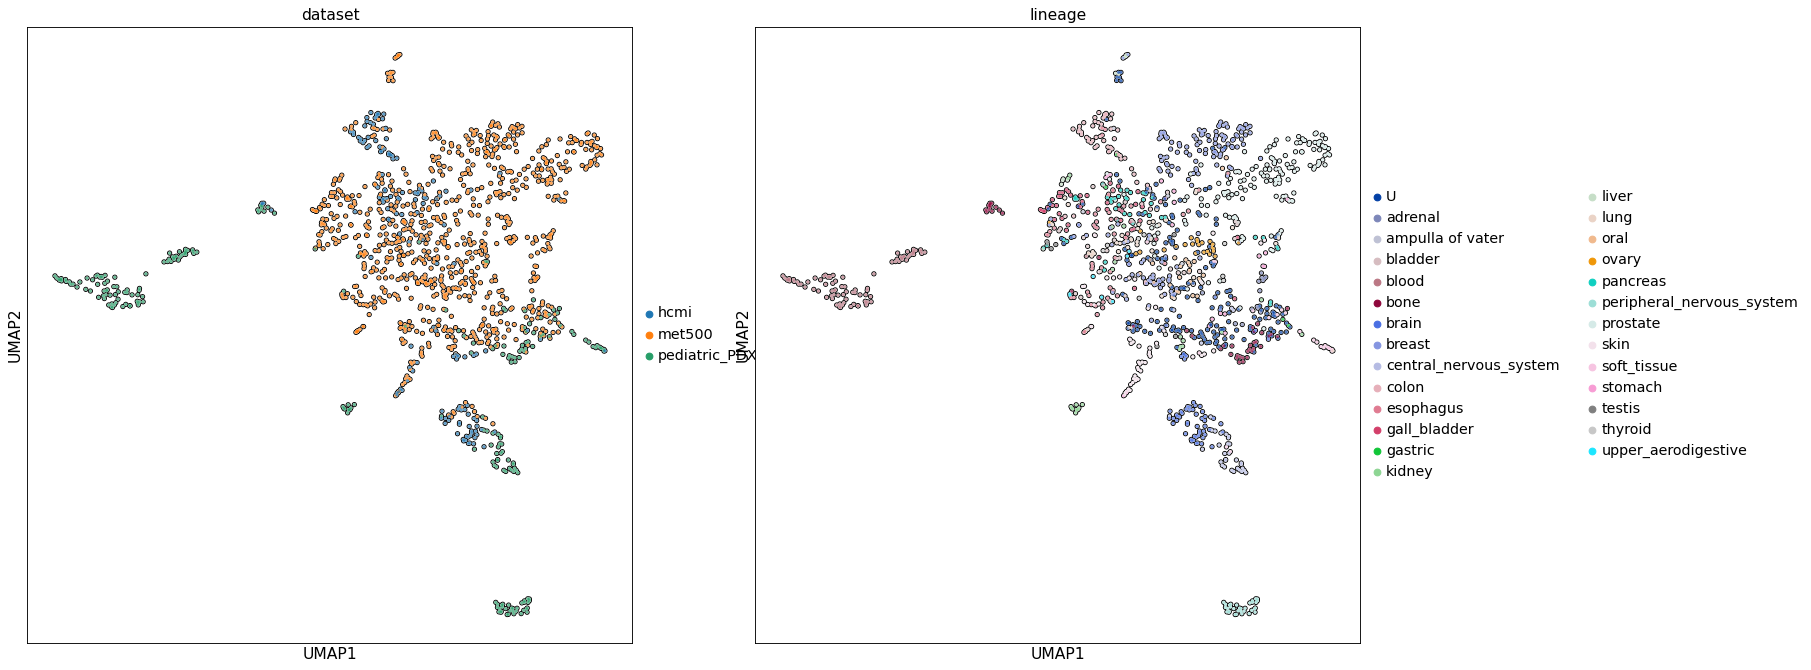

In [12]:
evaluator.plot_latent(umap_kwargs=dict( 
                            n_components=2,
                            min_dist=0.5,
                            alpha=1,
                            spread=1,
                            random_state=None), 
                    color=['dataset', 'lineage'],
                    projection="2d",
                    add_outline=True,
                    #rerun=False
                     )

In [7]:
evaluator = pl.CELLIGNER2_EVAL(cl2_less, additional_adata=dataset[~dataset.obs.dataset.isin(['met500', 'pediatric_PDX', 'hcmi'])])

In [8]:
evaluator.adata_latent.obs[['disease_type', 'sex', 'age', 'lineage']] = dataset.obs[['disease_type', 'sex', 'age', 'lineage']]

In [ ]:
sc.pp.neighbors(evaluator.adata_latent, )

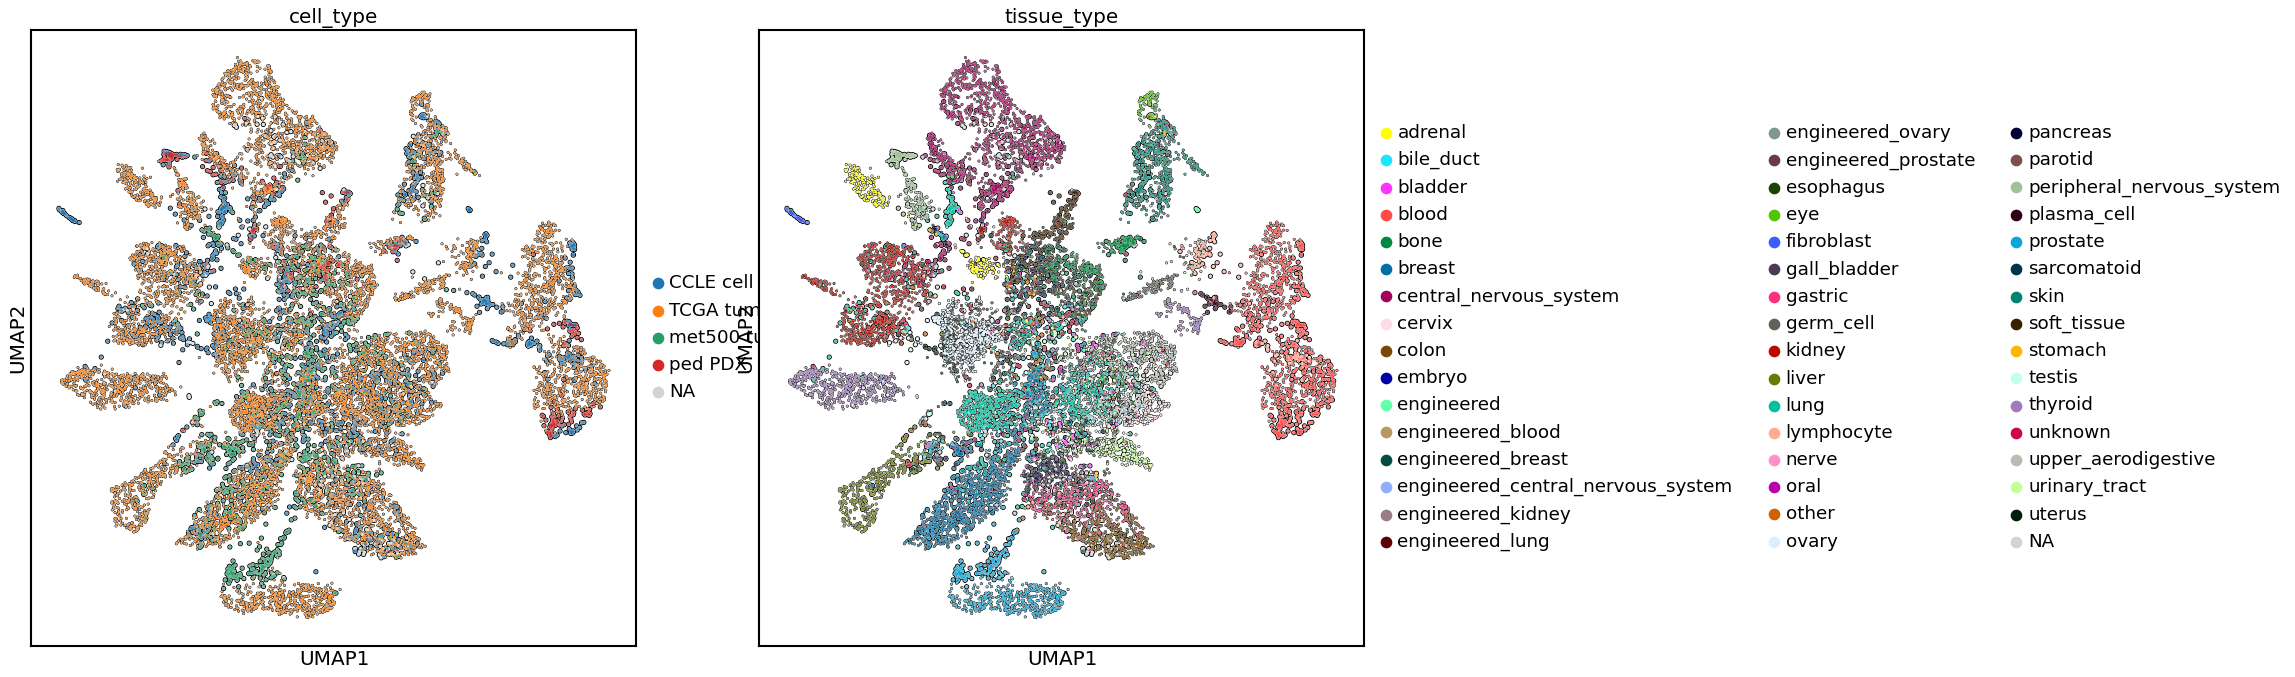

In [19]:
evaluator.plot_latent(umap_kwargs=dict( 
                            n_components=2,
                            min_dist=0.5,
                            alpha=1,
                            spread=1,
                            random_state=None), 
        color=['cell_type', 'tissue_type'],
        projection="2d",
        add_outline=True,
        rerun=False,
        size=[30 if i != 'tcga' else 10 for i in  evaluator.adata_latent.obs['dataset']])

/home/jeremie/miniconda3/envs/gae/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'dataset' as categorical


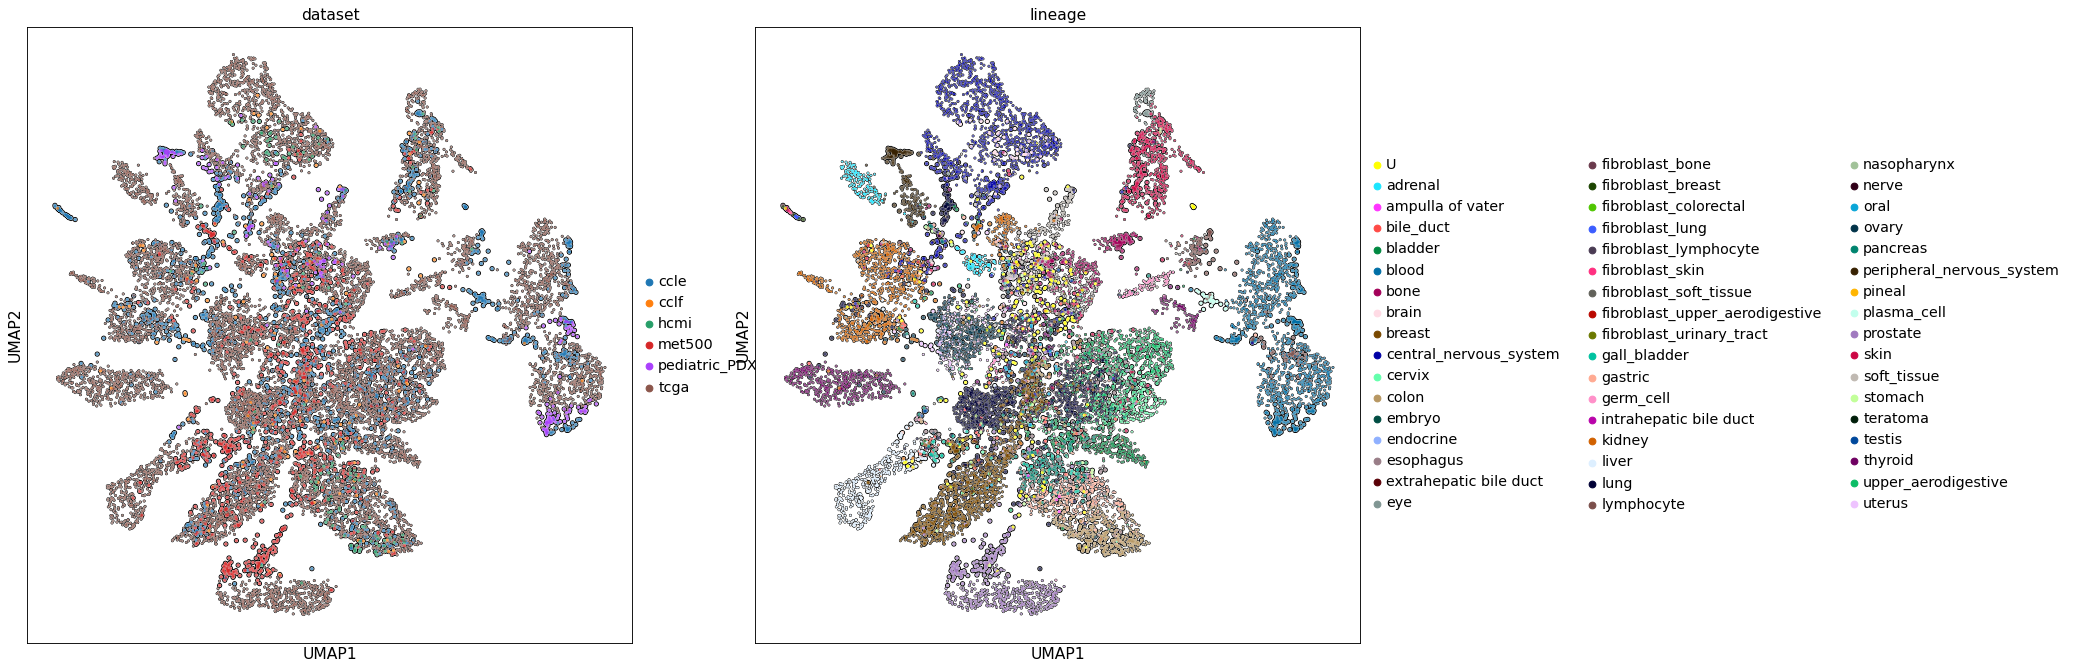

In [9]:
evaluator.plot_latent(umap_kwargs=dict( 
                            n_components=2,
                            min_dist=0.5,
                            alpha=1,
                            spread=1,
                            random_state=None), 
        color=['dataset', 'lineage'],
        projection="2d",
        add_outline=True,
        rerun=False,
        size=[30 if i != 'tcga' else 10 for i in  evaluator.adata_latent.obs['dataset']])

In [10]:
import scib

In [11]:
adata_obs = read_h5ad('../celligner/temp/adata.h5ad.gz').obs

/home/jeremie/miniconda3/envs/gae/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)


In [13]:
dataset.obs.drop(columns=['cell_type'], inplace=True)
#evaluator.adata_latent.obs.drop(columns=['cell_type', 'tissue_type'], inplace=True)

/home/jeremie/miniconda3/envs/gae/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


KeyError: "['cell_type', 'tissue_type'] not found in axis"

In [14]:
dataset.obs.loc[set(adata_obs.index) & set(evaluator.adata_latent.obs.index),['tissue_type','cell_type']] = adata_obs.loc[set(adata_obs.index) & set(evaluator.adata_latent.obs.index), ['tissue_type','cell_type']]

<ipython-input-14-1299a181a8a8>:1: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  dataset.obs.loc[set(adata_obs.index) & set(evaluator.adata_latent.obs.index),['tissue_type','cell_type']] = adata_obs.loc[set(adata_obs.index) & set(evaluator.adata_latent.obs.index), ['tissue_type','cell_type']]
<ipython-input-14-1299a181a8a8>:1: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  dataset.obs.loc[set(adata_obs.index) & set(evaluator.adata_latent.obs.index),['tissue_type','cell_type']] = adata_obs.loc[set(adata_obs.index) & set(evaluator.adata_latent.obs.index), ['tissue_type','cell_type']]


In [15]:
evaluator.adata_latent.obs.loc[set(adata_obs.index) & set(evaluator.adata_latent.obs.index),['tissue_type','cell_type']] = adata_obs.loc[set(adata_obs.index) & set(evaluator.adata_latent.obs.index), ['tissue_type','cell_type']]

<ipython-input-15-7c2f2c45576e>:1: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  evaluator.adata_latent.obs.loc[set(adata_obs.index) & set(evaluator.adata_latent.obs.index),['tissue_type','cell_type']] = adata_obs.loc[set(adata_obs.index) & set(evaluator.adata_latent.obs.index), ['tissue_type','cell_type']]
<ipython-input-15-7c2f2c45576e>:1: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  evaluator.adata_latent.obs.loc[set(adata_obs.index) & set(evaluator.adata_latent.obs.index),['tissue_type','cell_type']] = adata_obs.loc[set(adata_obs.index) & set(evaluator.adata_latent.obs.index), ['tissue_type','cell_type']]


In [16]:
loc = ~evaluator.adata_latent.obs.cell_type.isna()

In [17]:
dataset.obs.cell_type = dataset.obs.cell_type.astype('category')
dataset.obs.tissue_type = dataset.obs.tissue_type.astype('category')
evaluator.adata_latent.obs.cell_type = evaluator.adata_latent.obs.cell_type.astype('category')
evaluator.adata_latent.obs.tissue_type = evaluator.adata_latent.obs.tissue_type.astype('category')

In [18]:
evaluator.adata_latent.obsm['X_pca'] = evaluator.adata_latent.X

In [22]:
scib.metrics.metrics(dataset[evaluator.adata_latent[loc].obs.index], evaluator.adata_latent[loc], batch_key="cell_type", label_key='tissue_type', cell_cycle_=False, organism='human', trajectory_=False, isolated_labels_asw_=True, silhouette_=True, hvg_score_=False, graph_conn_=True, pcr_=True, isolated_labels_f1_=False, nmi_=True, ari_=True, kBET_=True, ilisi_=False, clisi_=False,)

/home/jeremie/miniconda3/envs/gae/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
Trying to set attribute `.obs` of view, copying.


NMI...
ARI...
Silhouette score...


/home/jeremie/miniconda3/envs/gae/lib/python3.8/site-packages/scib/metrics/silhouette.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sil_all = sil_all.append(
/home/jeremie/miniconda3/envs/gae/lib/python3.8/site-packages/scib/metrics/silhouette.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sil_all = sil_all.append(
/home/jeremie/miniconda3/envs/gae/lib/python3.8/site-packages/scib/metrics/silhouette.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sil_all = sil_all.append(
/home/jeremie/miniconda3/envs/gae/lib/python3.8/site-packages/scib/metrics/silhouette.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sil_all = 

PC regression...
Isolated labels ASW...
Graph connectivity...
kBET...


0
NMI_cluster/label          0.706200
ARI_cluster/label          0.539943
ASW_label                  0.503802
ASW_label/batch            0.795120
PCR_batch                  0.866565
cell_cycle_conservation         NaN
isolated_label_F1               NaN
isolated_label_silhouette  0.471351
graph_conn                 0.745206
kBET                            NaN
iLISI                           NaN
cLISI                           NaN
hvg_overlap                     NaN
trajectory                      NaN

## only class on tumors

In [52]:
toprovide = dataset.copy()
toprovide.obs.loc[toprovide.obs.cell_type=="historical_cl",['tissue_type', 'age', "sex", 'disease_type']] = "U"

In [53]:
cl2_less = celligner2.CELLIGNER2(
    adata=toprovide,
    condition_keys=['cell_type'],
    predictor_keys=['tissue_type', 'age', "sex", 'disease_type'],
    hidden_layer_sizes=[256, 128],
    classifier_hidden_layer_sizes=[32,64],
    use_mmd = True,
    latent_dim=16,
    beta=500,
    betaclass=0.8
)
cl2_less.train(
    n_epochs=300,
    alpha_epoch_anneal=200,
    cell_type_key='tissue_type',
    early_stopping_kwargs= {
        "early_stopping_metric": "val_unweighted_loss",
        "threshold": 0,
        "patience": 20,
        "reduce_lr": True,
        "lr_patience": 13,
        "lr_factor": 0.1,
    },
    alpha_kl=0.001,
    train_frac=0.75,
    #batch_size=100,
    #monitor_only_val=False,
    n_workers=16,
    min_weight=0.000001,
)


INITIALIZING NEW NETWORK..............
Encoder Architecture:
	Input Layer in, out and cond: 3000 256 2
	Hidden Layer 1 in/out: 256 128
	Mean/Var Layer in/out: 128 16
Classifier Architecture:
	First Layer in/out:  16 32
	Hidden Layer 1 in/out: 32 64
	Output Layer in/out:  64 59 

Decoder Architecture:
	First Layer in, out and cond:  16 128 2
	Hidden Layer 1 in/out: 128 256
	Output Layer in/out:  256 3000 



/home/jeremie/celligner2/celligner2/dataset/celligner2/anndata.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.goodloc = torch.tensor(goodloc, dtype=torch.bool)


Therefore integer value of those labels is set to -1
Therefore integer value of those labels is set to -1
Therefore integer value of those labels is set to -1
Therefore integer value of those labels is set to -1
Therefore integer value of those labels is set to -1
Therefore integer value of those labels is set to -1
Therefore integer value of those labels is set to -1
Therefore integer value of those labels is set to -1


/home/jeremie/miniconda3/envs/gae/lib/python3.8/site-packages/torch/utils/data/dataloader.py:478: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 12, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


 |██████--------------| 31.7%  - val_loss: 4933.4323730469 - val_recon_loss: 4557.9357346755 - val_kl_loss: 65.7662957998 - val_class_ce_loss: 69.2670529439 - val_mmd_loss: 306.1988167396
ADJUSTED LR
 |████████------------| 44.7%  - val_loss: 4876.4743088942 - val_recon_loss: 4532.9872859075 - val_kl_loss: 65.8623240544 - val_class_ce_loss: 54.2194379660 - val_mmd_loss: 289.2236691988
ADJUSTED LR
 |██████████----------| 50.7%  - val_loss: 4853.7487229567 - val_recon_loss: 4528.9729567308 - val_kl_loss: 65.8627219567 - val_class_ce_loss: 54.2605086107 - val_mmd_loss: 270.4654816848
ADJUSTED LR
 |██████████----------| 53.0%  - val_loss: 4869.1136568510 - val_recon_loss: 4529.7173227163 - val_kl_loss: 65.8627178486 - val_class_ce_loss: 54.2622828850 - val_mmd_loss: 285.0817912175
Stopping early: no improvement of more than 0 nats in 20 epochs
If the early stopping criterion is too strong, please instantiate it with different parameters in the train method.
Saving best state of network...


In [57]:
from celligner2 import plotting as pl
evaluator = pl.CELLIGNER2_EVAL(cl2_less)

In [58]:
evaluator.adata_latent.obs[['tissue_type', 'disease_type', 'sex', 'age']] = dataset.obs[['tissue_type', 'disease_type', 'sex', 'age']]

/home/jeremie/miniconda3/envs/gae/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'cell_type' as categorical
/home/jeremie/miniconda3/envs/gae/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'tissue_type' as categorical
/home/jeremie/miniconda3/envs/gae/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will 

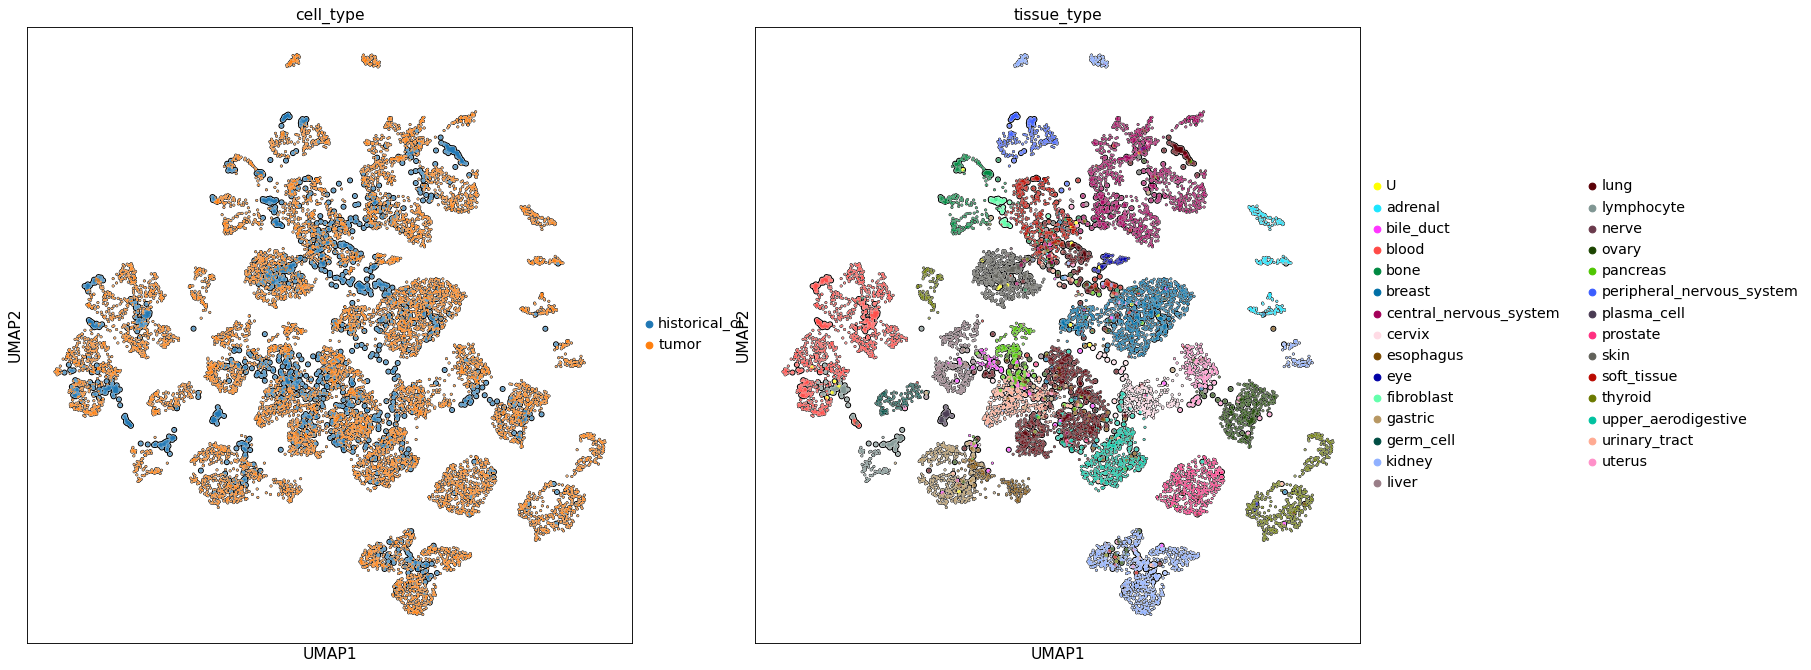

In [59]:
evaluator.plot_latent(umap_kwargs=dict( 
                            n_components=2,
                            min_dist=0.5,
                            alpha=1,
                            spread=1,
                            random_state=None), 
        color=['cell_type', 'tissue_type'],
        projection="2d",
        add_outline=True,
        size=[40]*len(dataset[dataset.obs['cell_type']=='historical_cl']) + [10]*len(dataset[dataset.obs['cell_type']=='tumor']))

In [62]:
evaluator.get_class_quality(only="historical_cl", classes=['tissue_type', 'disease_type', 'sex', 'age'])

tissue_type
all predicted categories:  {'upper_aerodigestive', 'germ_cell', 'kidney', 'gastric', 'prostate', 'adrenal', 'lung', 'bone', 'thyroid', 'eye', 'bile_duct', 'soft_tissue', 'pancreas', 'lymphocyte', 'ovary', 'urinary_tract', 'liver', 'esophagus', 'uterus', 'skin', 'blood', 'peripheral_nervous_system', 'breast', 'central_nervous_system', 'cervix'}
accuracy:  0.45897832817337464
F1 Score (weigthed): 0.48
F1 Score (macro): 0.36


disease_type
all predicted categories:  {'Liver Cancer', 'Prostate Cancer', 'Germ Cell Cancer', 'Bile Duct Cancer', 'Sarcoma', 'Ovarian Cancer', 'Thymus Cancer', 'Lung Cancer', 'Adrenal Cancer', 'Esophageal Cancer', 'Lymphoma', 'Cervical Cancer', 'Breast Cancer', 'Bladder Cancer', 'Brain Cancer', 'Skin Cancer', 'Pancreatic Cancer', 'Neuroblastoma', 'Thyroid Cancer', 'Eye Cancer', 'Kidney Cancer', 'Head and Neck Cancer', 'Endometrial/Uterine Cancer', 'Bone Cancer', 'Leukemia', 'Gastric Cancer'}
accuracy:  0.4550989345509893
F1 Score (weigthed): 0.48
F1 Sc

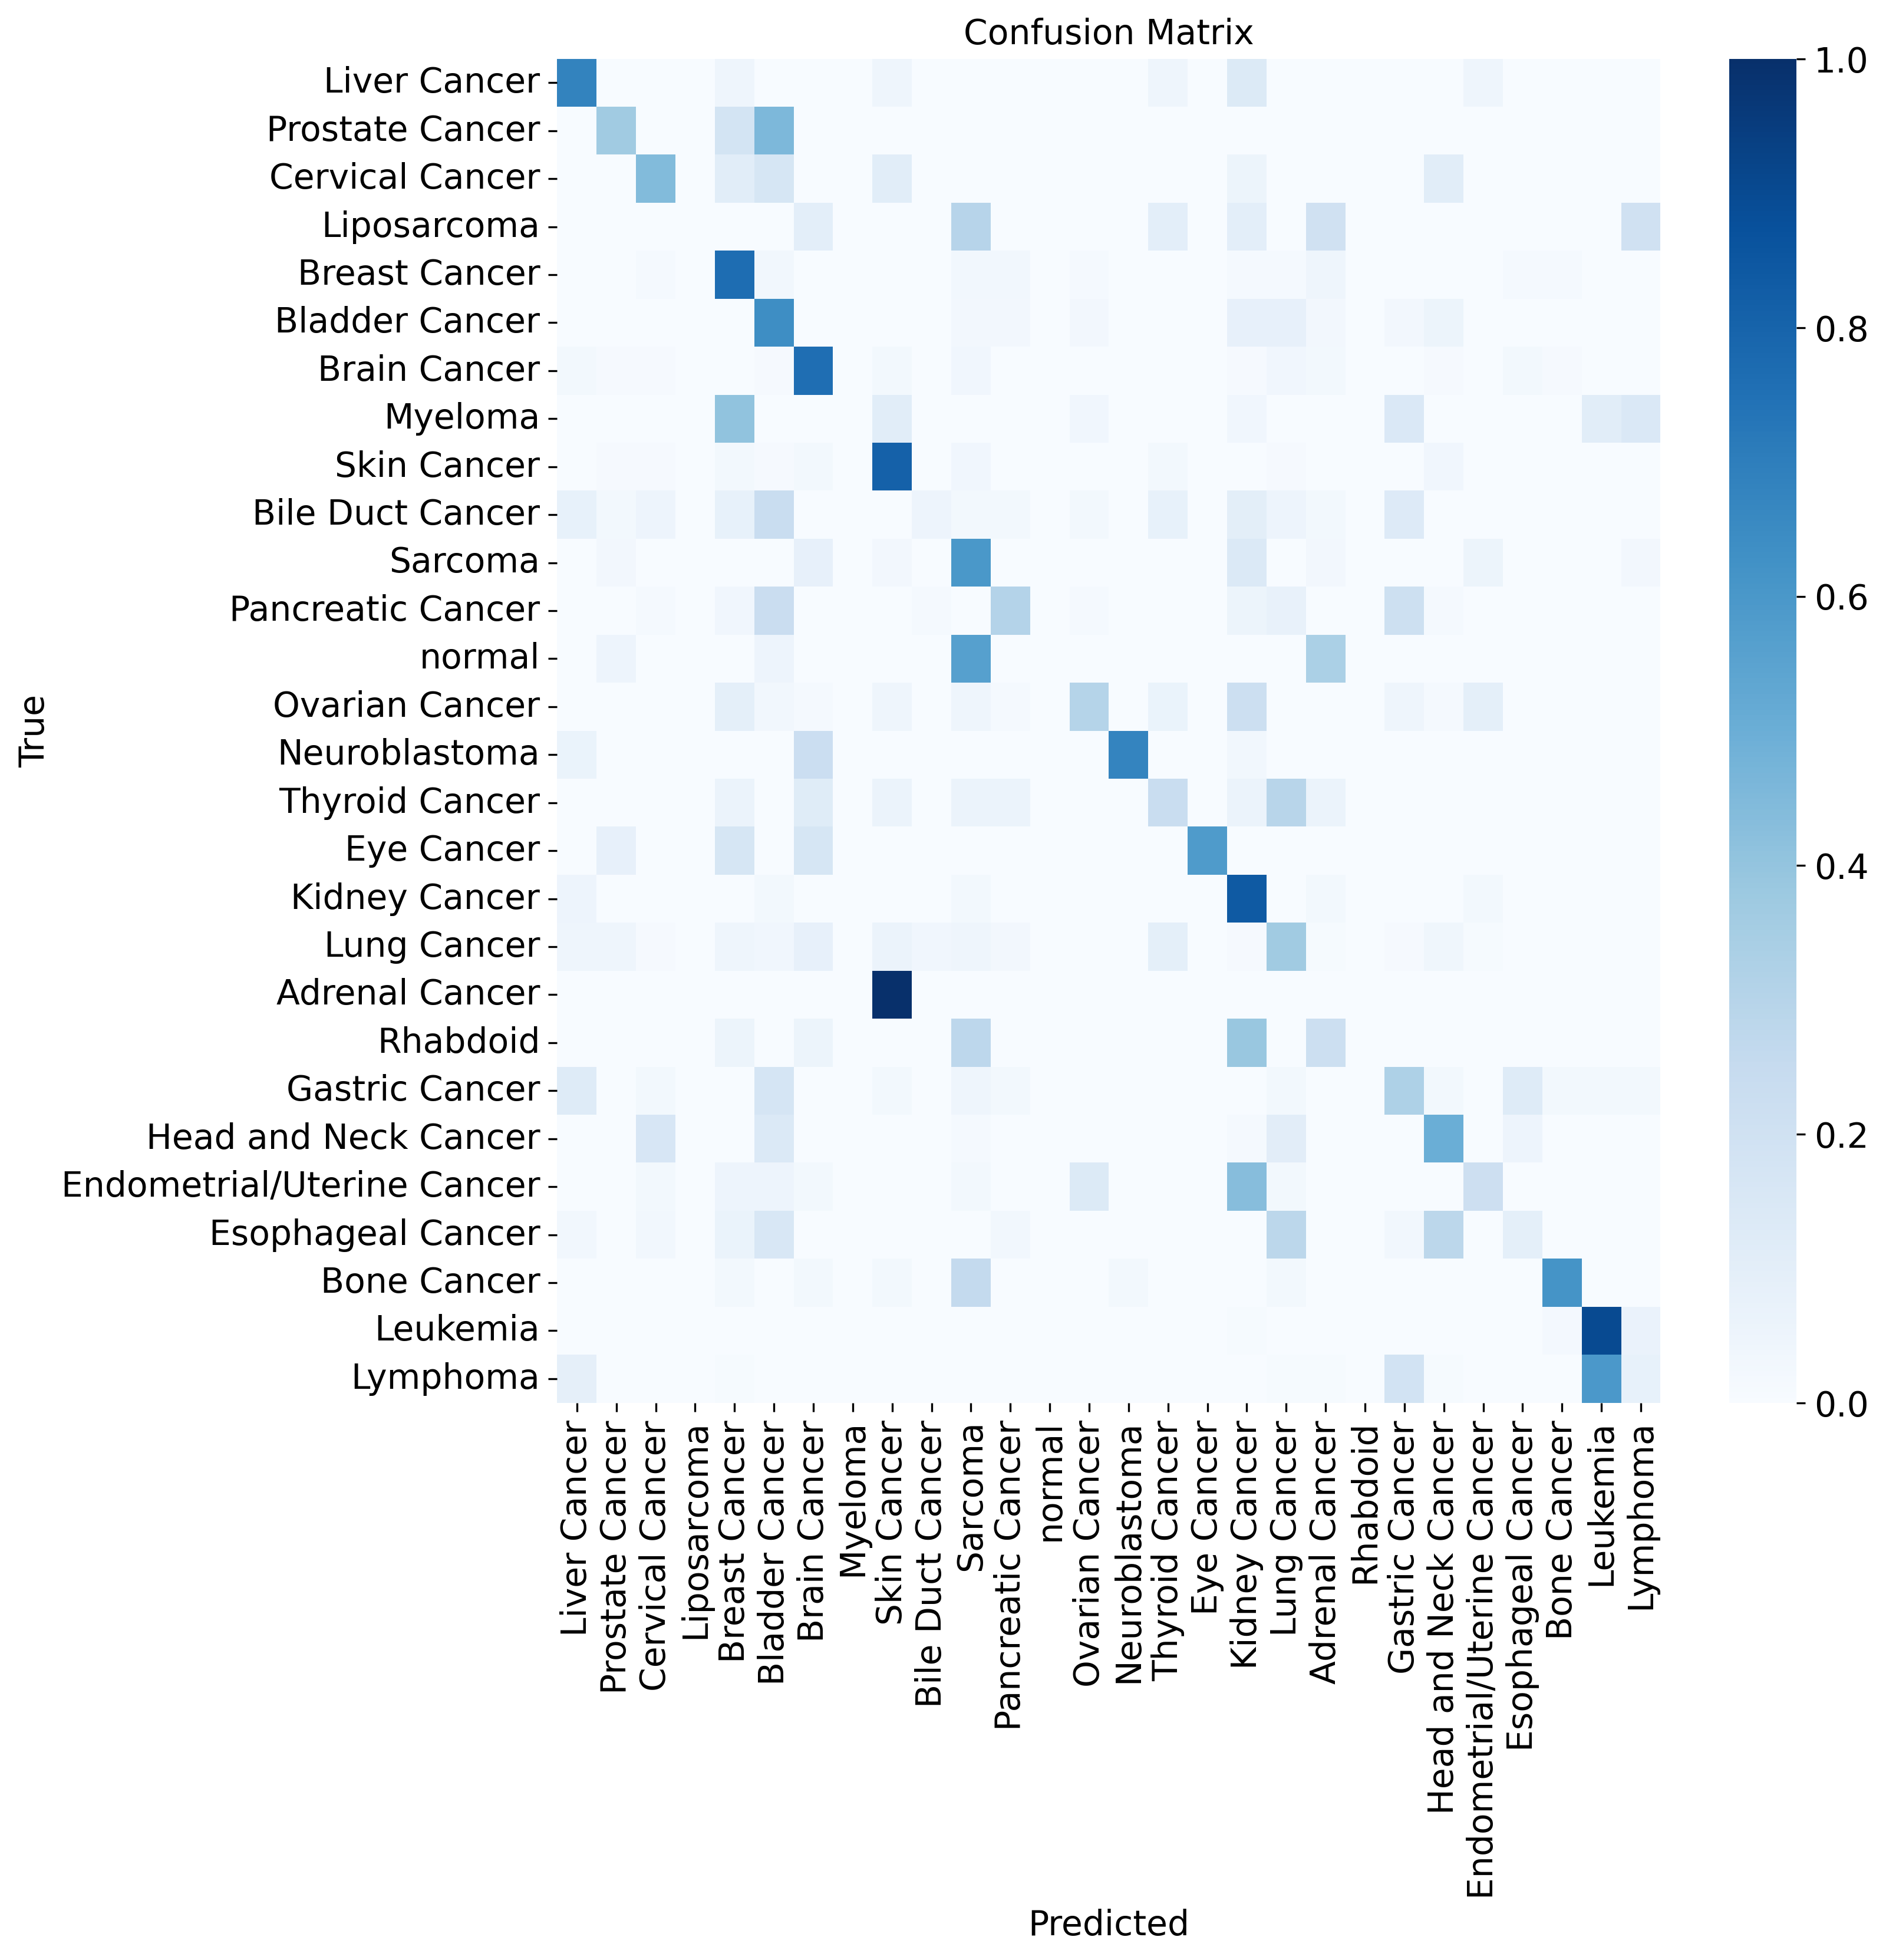

In [61]:
conf = evaluator.getconfusionMatrix(only='historical_cl', of="disease_type")

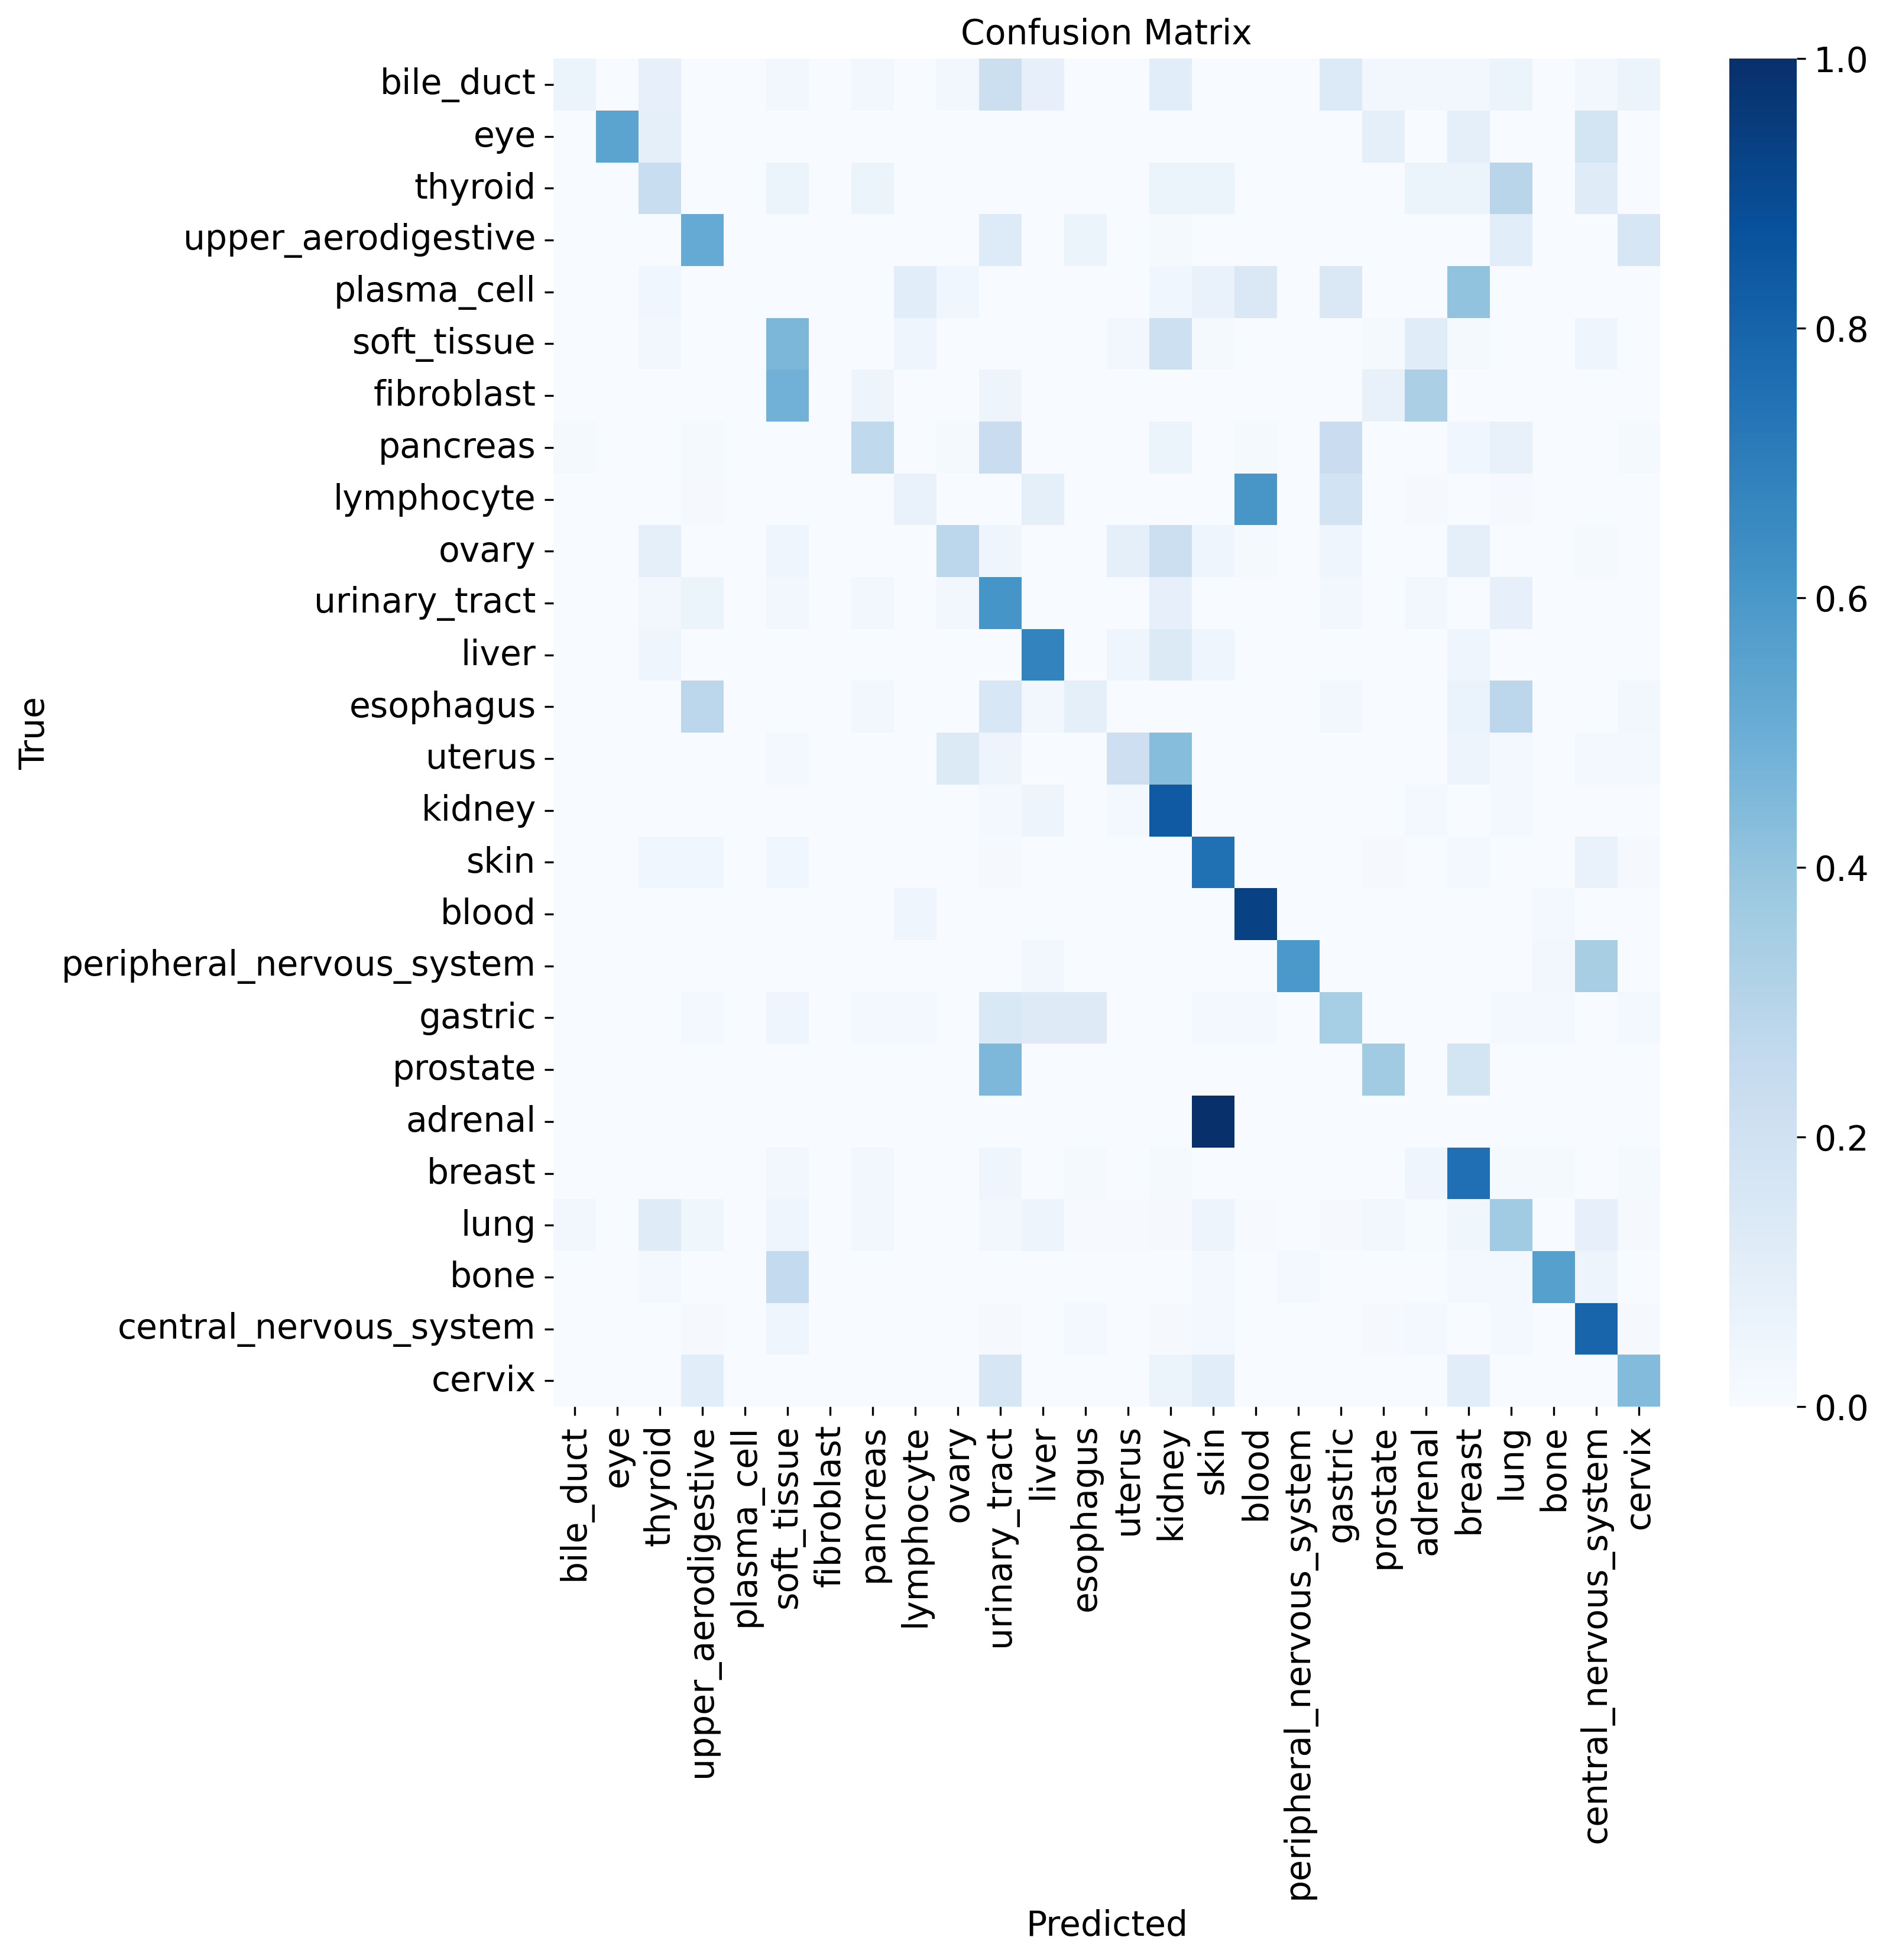

In [60]:
conf = evaluator.getconfusionMatrix(only="historical_cl")

/home/jeremie/celligner2/celligner2/plotting/_alluvial.py:156: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(alluvial_fan)


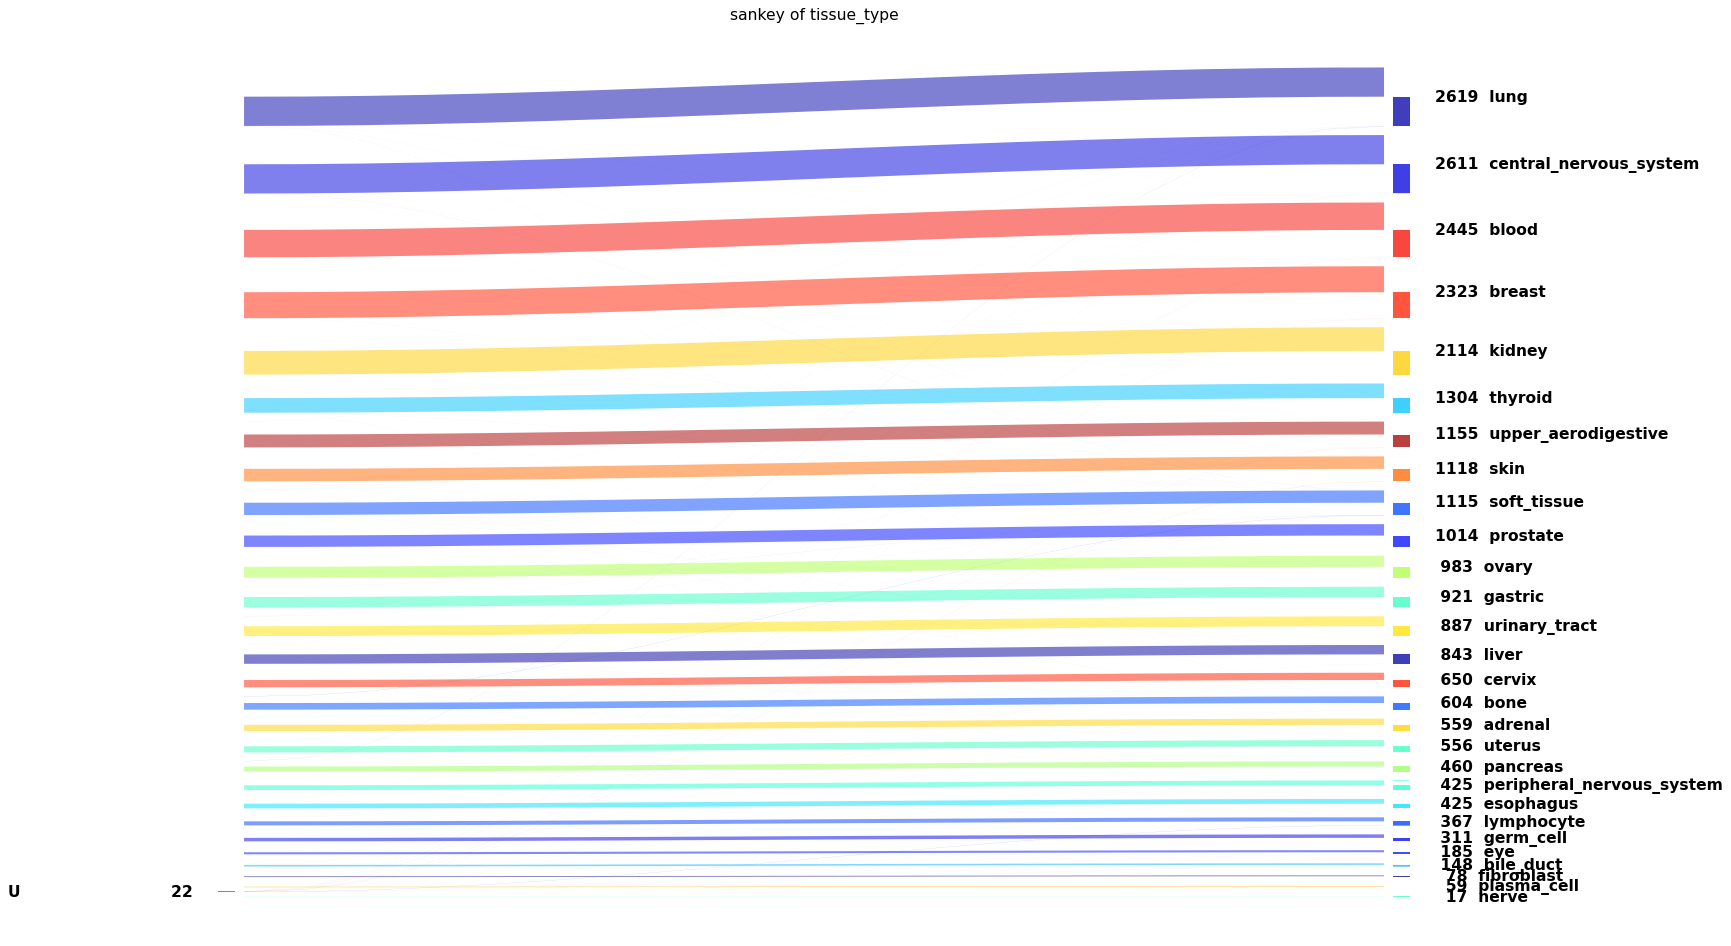

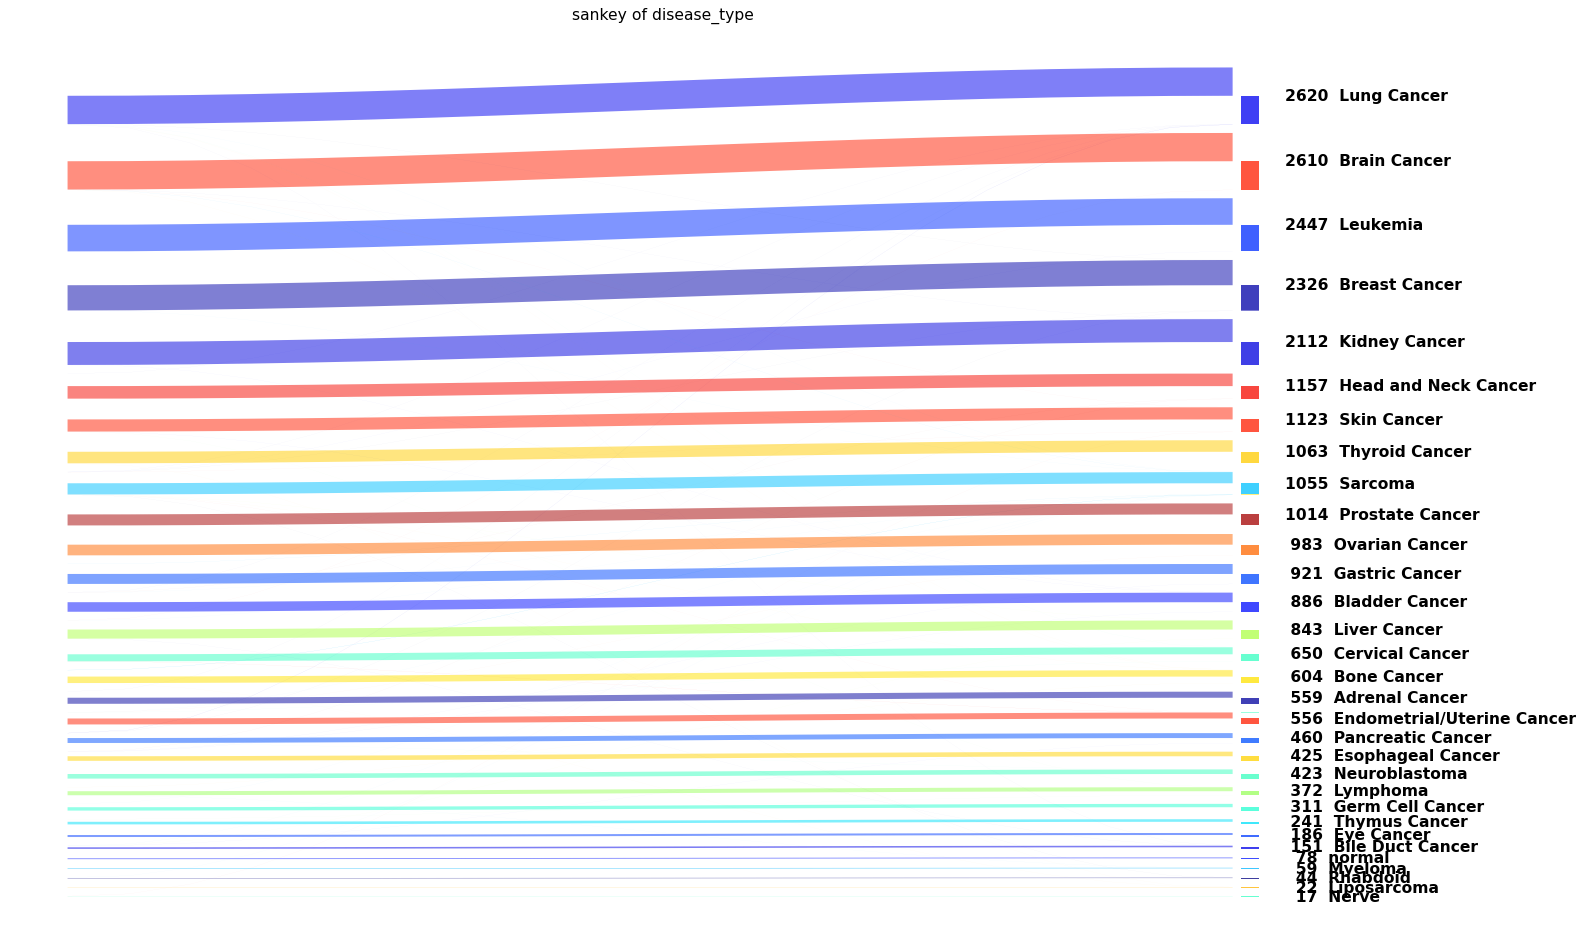

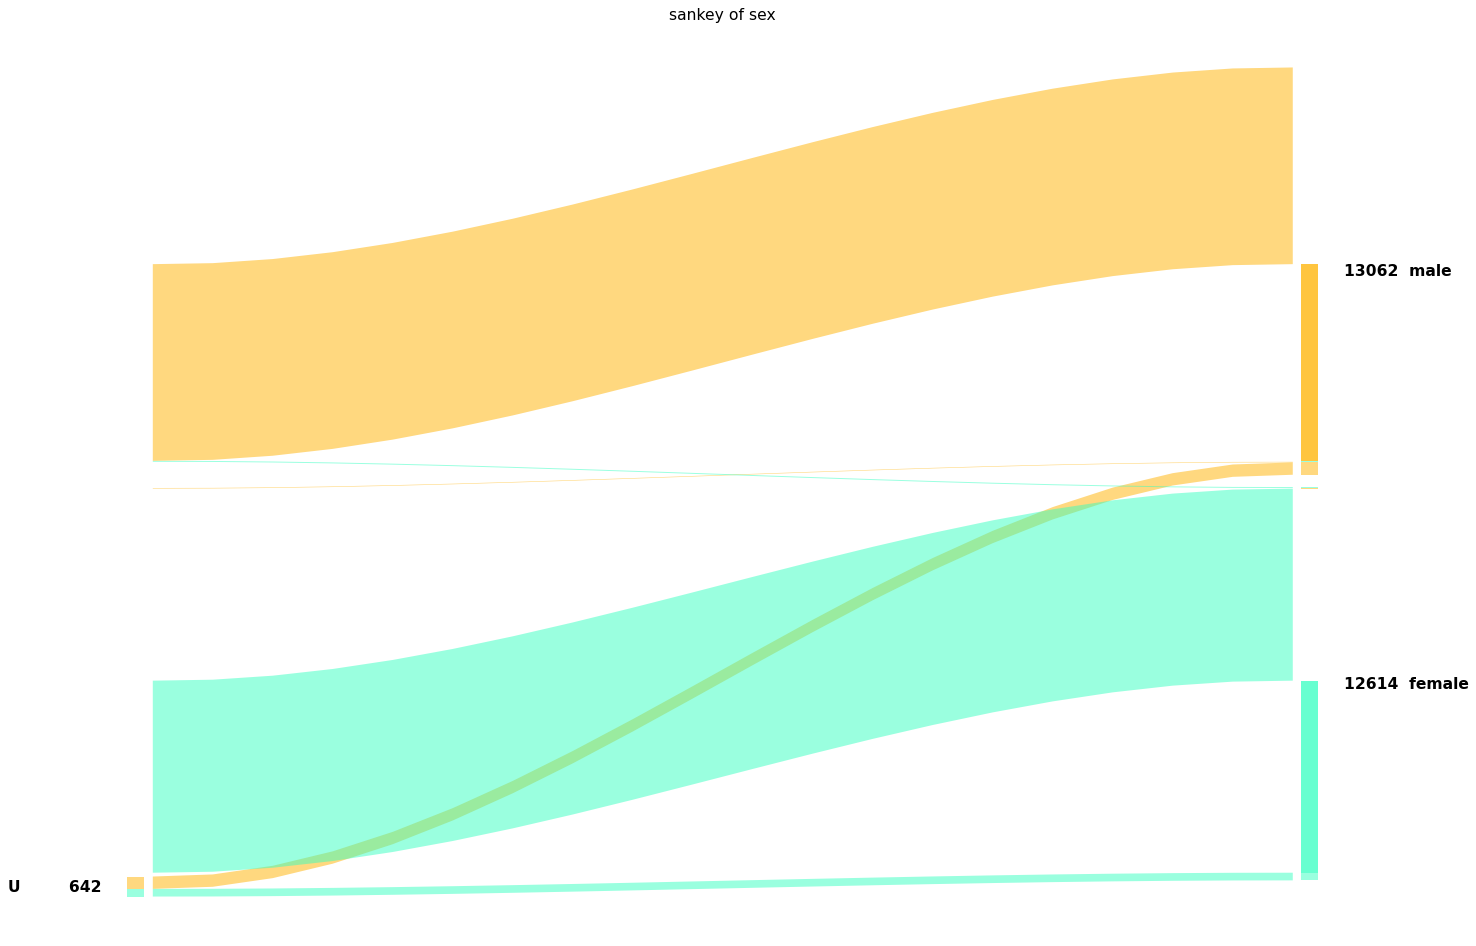

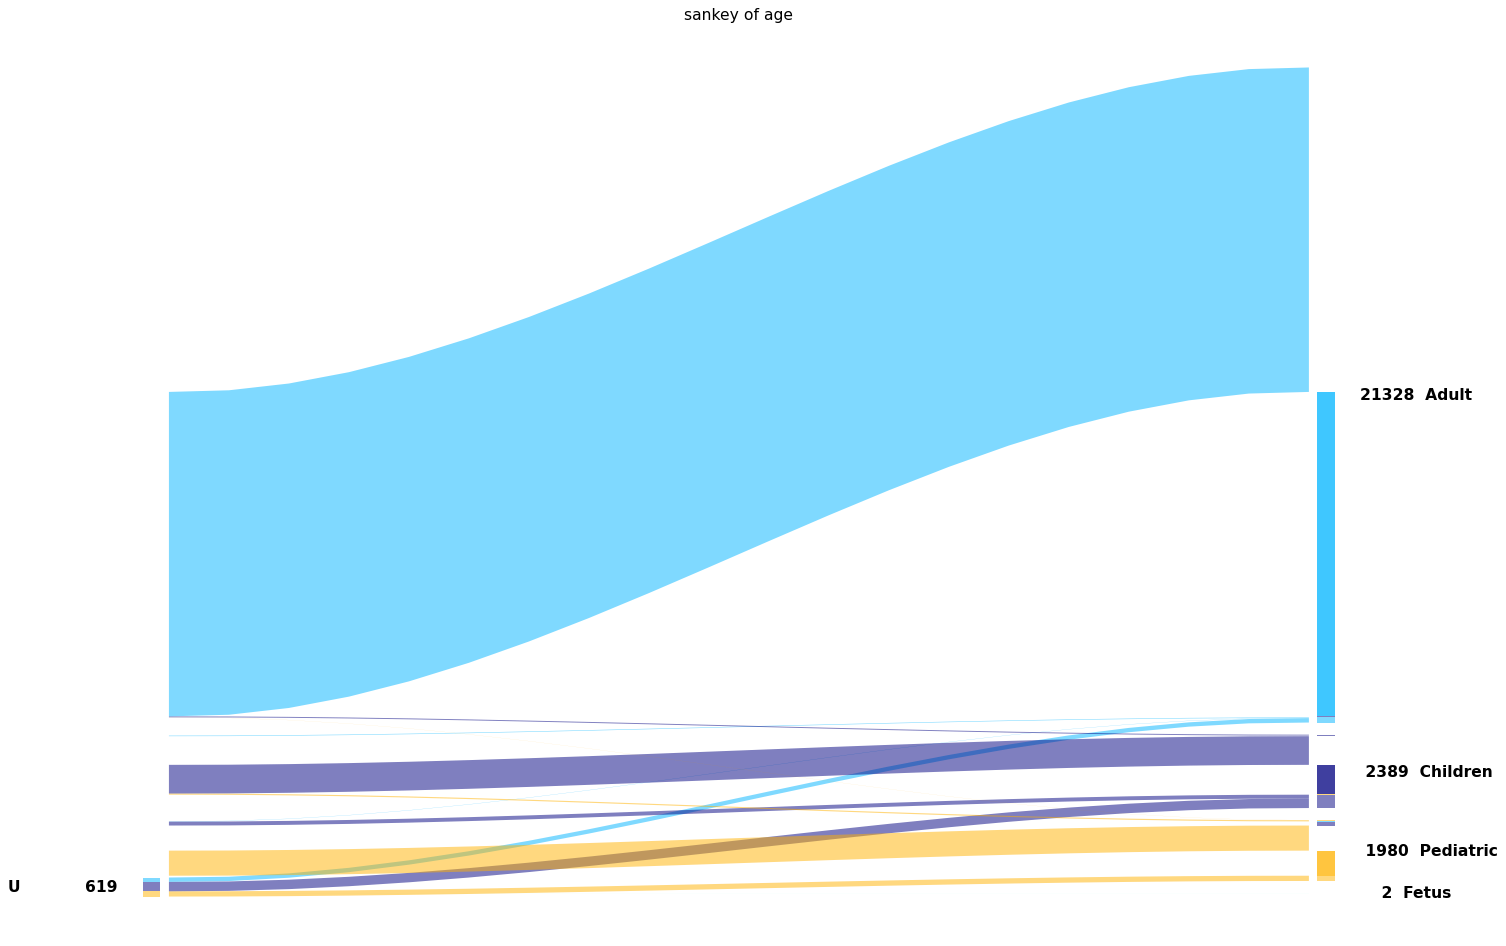

In [277]:
evaluator.plot_classification(classes=['tissue_type', 'disease_type', 'sex', 'age'])

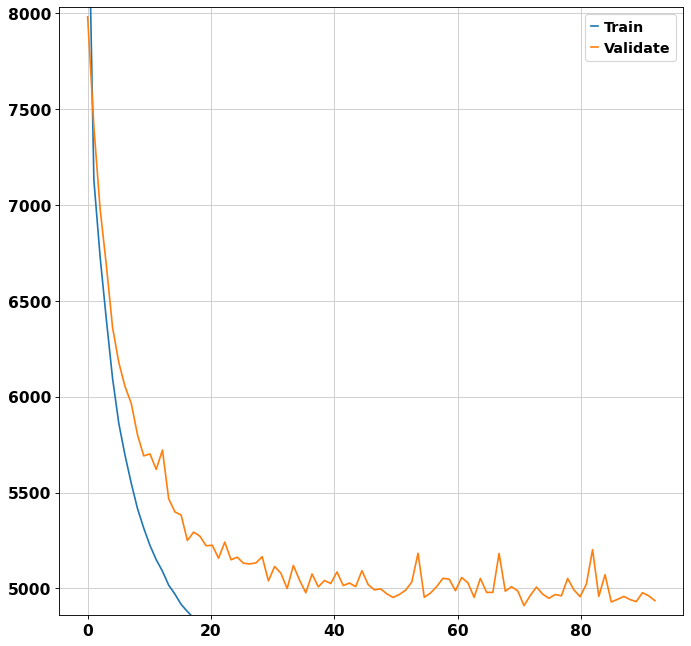

<Figure size 800x800 with 0 Axes>

In [285]:
evaluator.plot_history()

In [279]:
evaluator.get_asw()
evaluator.get_latent_score()
evaluator.get_nmi()

silhouette score...
ASW on batch: 0.8548363904456818
ASW on celltypes: 0.626011461019516
Calculating EBM with n_cat = 29
Latent-Space Score EBM+KNN, EBM, KNN: 0.93, 0.03, 0.90


ModuleNotFoundError: No module named 'louvain'

## log

In [86]:
import seaborn as sns

/home/jeremie/miniconda3/envs/gae/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

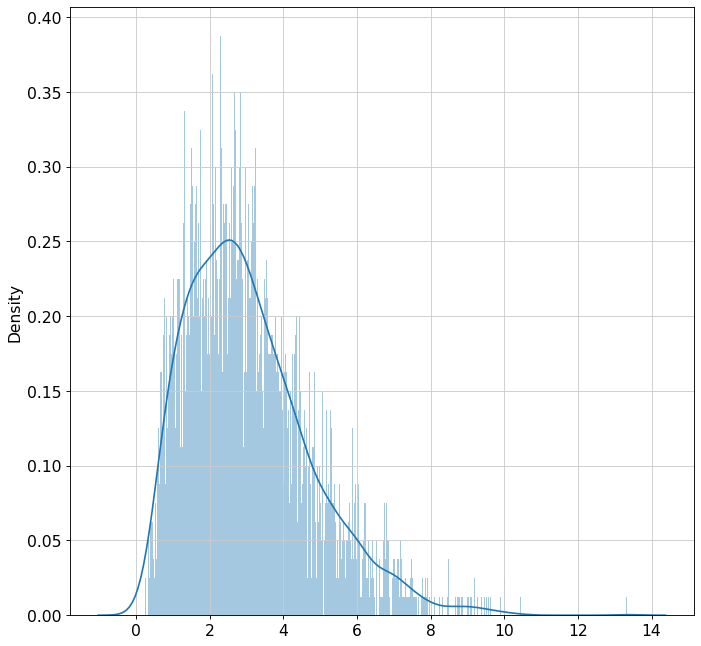

In [96]:
sns.distplot(toprovide.X[-200:].mean(0), bins=500)

/home/jeremie/miniconda3/envs/gae/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

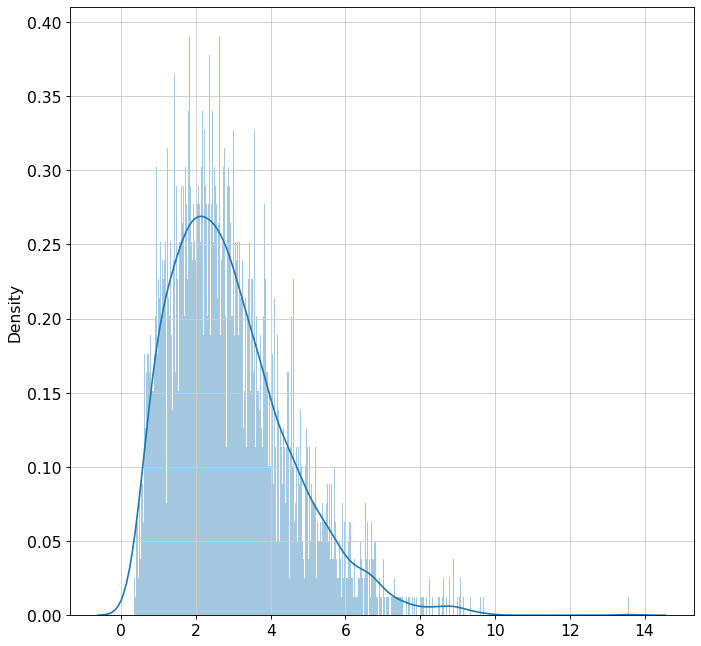

In [97]:
sns.distplot(toprovide.X.mean(0), bins=500)

/home/jeremie/miniconda3/envs/gae/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

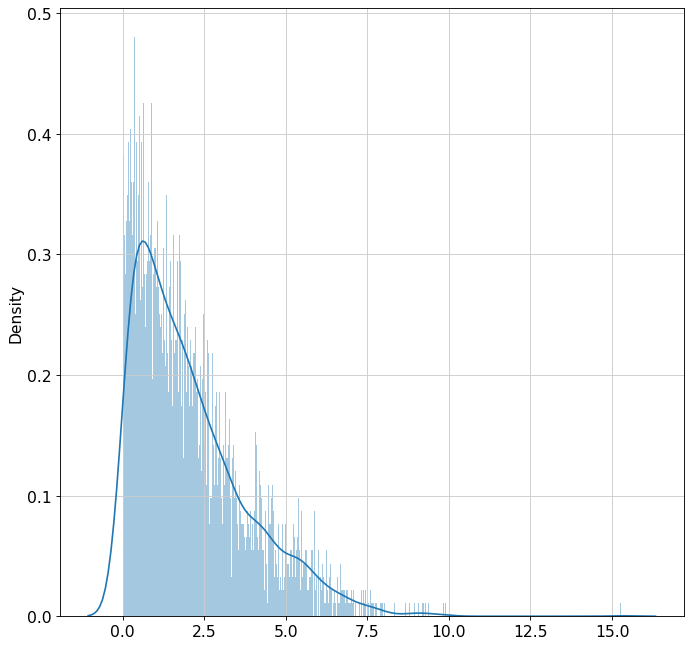

In [95]:
sns.distplot(toprovide.X[:200].mean(0), bins=500)

#### without double log

         Falling back to preprocessing with `sc.pp.pca` and default params.
/home/jeremie/miniconda3/envs/gae/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'sex' as categorical


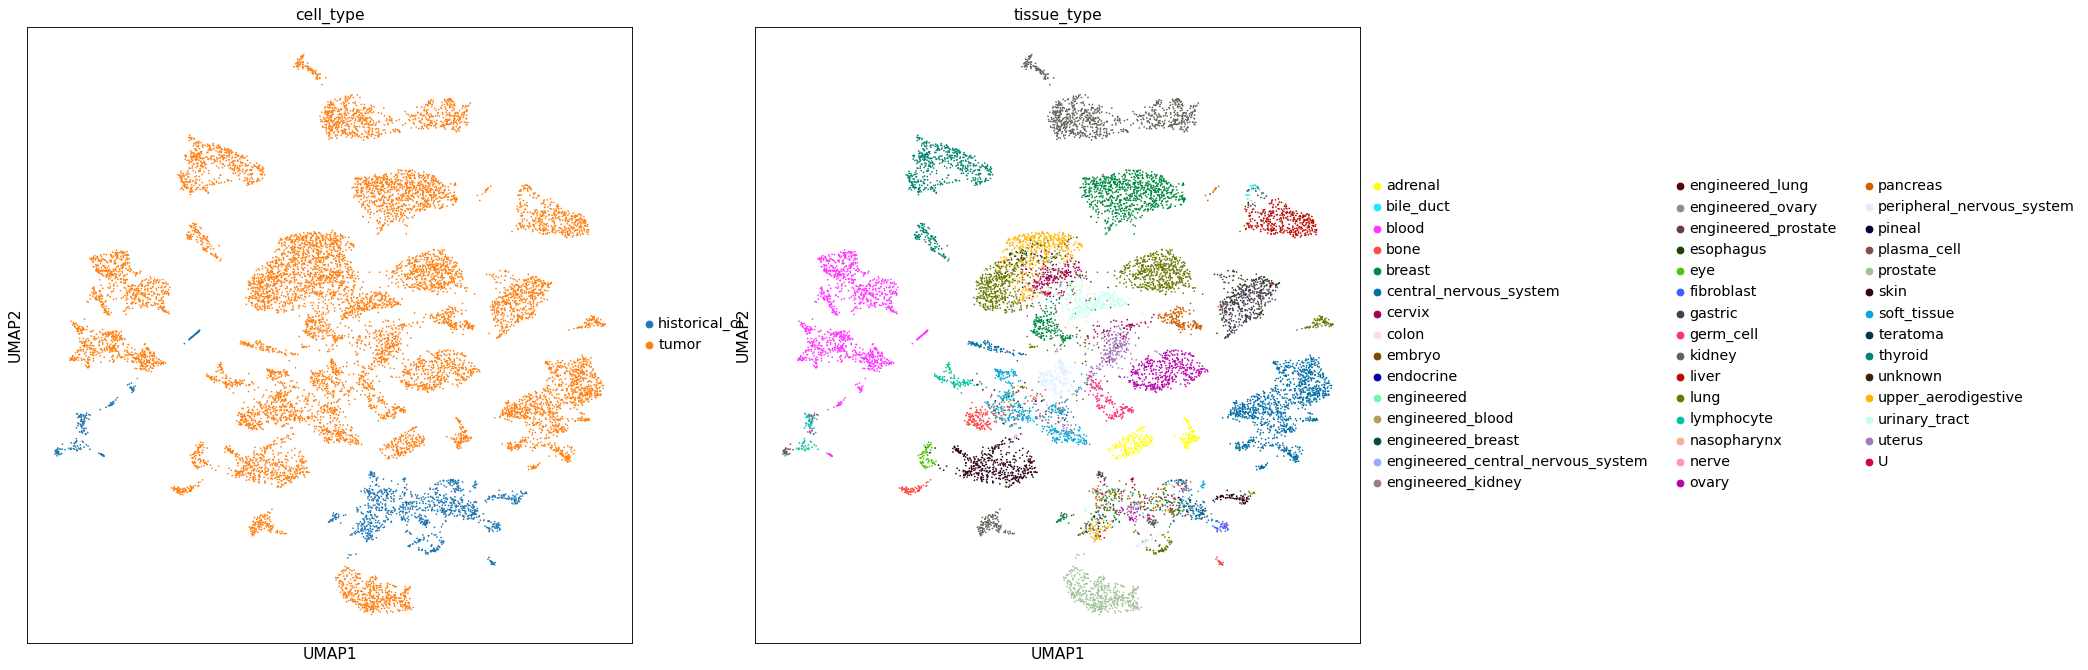

In [271]:
sc.pp.neighbors(dataset, n_neighbors=8)
sc.tl.umap(dataset, min_dist=0.5,
                            alpha=1,
                            spread=1)
sc.pl.umap(dataset,
        color=['cell_type', 'tissue_type'],
        projection="2d",)